## 오토인코더
- **인코더**의 역할을 맡아 각 의류 아이템을 옷장의 특정 위치로 이동하며 이 과정을 **인코딩**이라 한다.
- 브라이언은 **디코더**의 역할을 맡아 옷장의 한 위치를 받아 해당 아이템을 다시 생성하려고 시도한다. 이 과정을 **디코딩**이라 한다.

In [46]:
# 패션 MNIST 데이터셋 로드

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [68]:
# 파라미터
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [47]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [48]:
# 데이터 전처리
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

- 원본 이미지는 28X28 크기 흑백 이미지(픽셀 값은 0~255)이므로 픽셀 값을 0~1 사이로 조정해야 한다.
- 또한 위 예제처럼 이미지가 신경망을 통과할 때 텐서 크기를 쉽게 조작할 수있도록 각 이미지에 패딩을 추가하여 32X32 크기로 만든다.

In [49]:
#1 인코더의 Input 층(이미지)을 정의
encoder_input = layers.Input(
	shape=(32, 32,1), name = "encoder_input"
)
#2 순서대로 Conv2D 층을 쌓는다.
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
	encoder_input
)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

#3 마지막 합성곱 층의 출력을 벡터로 펼침
x = layers.Flatten()(x)
#4 이 벡터를 2D 임베딩에 해당하는 Dense 층에 연결
encoder_output = layers.Dense(2, name="encoder_output")(x)

#5 케라스 Model 클래스로 인코더를 정의. 이 모델은 입력 이미지를 받아 이를 2D 임베딩에 인코딩한다.
encoder = models.Model(encoder_input, encoder_output)

In [50]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

In [51]:
#1 디코더의 Input층 (임베딩)을 정의
decoder_input = layers.Input(shape=(2,), name="decoder_input")

#2 입력을 Dense 층에 연결
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
#3 첫 번째 Conv2Dtranspose 층에 입력으로 주입할 수 있도록 Reshape 층의 벡터의 크기를 바꾼다.
x = layers.Reshape(shape_before_flattening)(x)
#4 Conv2DTranspose 층을 연속으로 쌓음
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation = 'relu', padding="same")(x)
decoder_output = layers.Conv2D(
	1,
	(3,3),
	strides = 1,
	activation="sigmoid",
	padding="same",
	name="decoder_output"
)(x)

#5 케라스 Model 클래스로 디코더를 정의
#5 이 모델은 잠재 공간의 임베딩을 받아 원본 이밎 도메인으로 디코
decoder = models.Model(decoder_input, decoder_output)

In [52]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

- 케라스 Model 클래스로 완전한 오토인코더를 정의
- 이 모델은 이미지를 입력으로 받아 인코더와 디코더를 통과시켜 원본 이미지의 재구성을 생성

In [53]:
# 완전한 오토인코더
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_4 (Functional)        (None, 32, 32, 1)         2462

In [54]:
# 오토인코더 컴파일
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [55]:
# 오토인코더 훈련하기
autoencoder.fit(
    x_train,
    x_train,
    epochs = 5,
    batch_size=100,
    shuffle = True,
    validation_data = (x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 65s 106ms/step - loss: 0.2977 - val_loss: 0.2654
Epoch 2/5
600/600 [==============================] - 73s 122ms/step - loss: 0.2607 - val_loss: 0.2582
Epoch 3/5
600/600 [==============================] - 130s 216ms/step - loss: 0.2553 - val_loss: 0.2549
Epoch 4/5
600/600 [==============================] - 157s 262ms/step - loss: 0.2528 - val_loss: 0.2538
Epoch 5/5
600/600 [==============================] - 158s 263ms/step - loss: 0.2512 - val_loss: 0.2525


In [56]:
# 최종 모델 저장

autoencoder.save("/models/autoencoder")
encoder.save("/models/encoder")
decoder.save("/models/decoder")

INFO:tensorflow:Assets written to: /models/autoencoder\assets


INFO:tensorflow:Assets written to: /models/autoencoder\assets


INFO:tensorflow:Assets written to: /models/encoder\assets


INFO:tensorflow:Assets written to: /models/encoder\assets


INFO:tensorflow:Assets written to: /models/decoder\assets


INFO:tensorflow:Assets written to: /models/decoder\assets


In [63]:
# 오토인코더를 사용하여 이미지 재구성하기
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 6ms/step


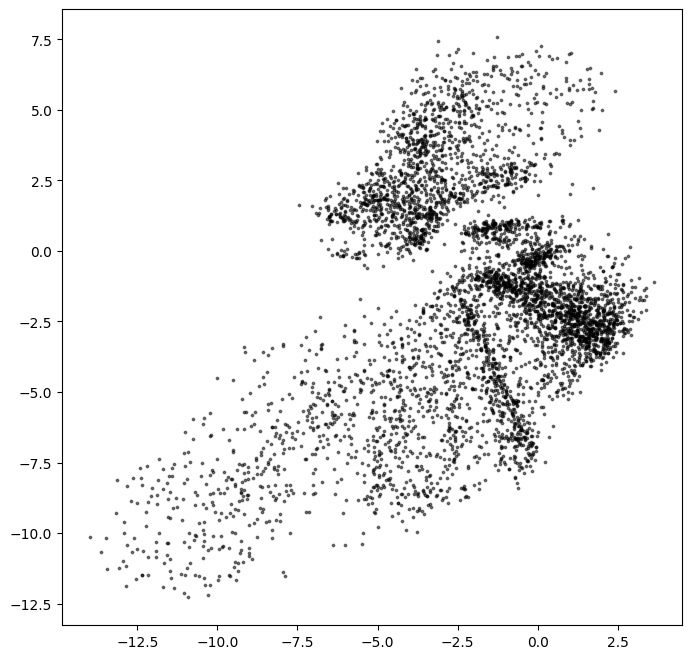

In [64]:
# 샘플 이미지를 인코딩
embeddings = encoder.predict(example_images)

# 2D 공간에 인코딩된 포인트를 출력
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

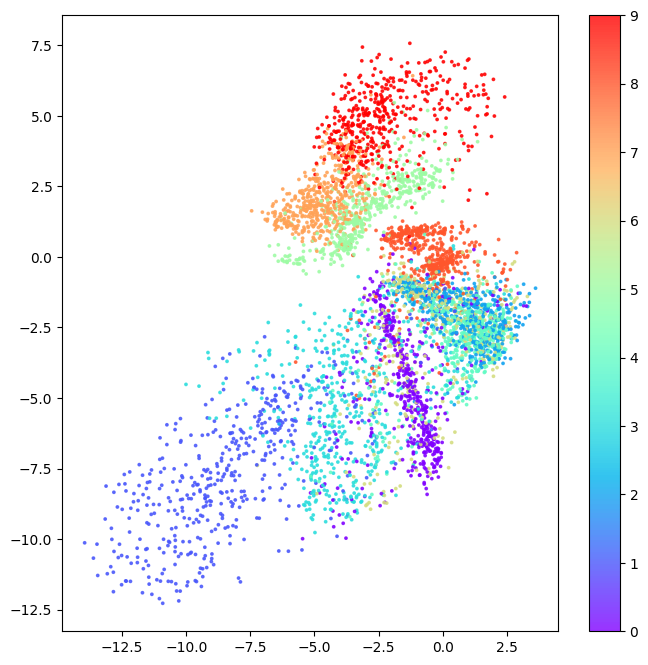

In [65]:
# 레이블(의류 종류)에 따라 임베딩에 색을 입힙니다.
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [69]:
# 디코더를 사용해 새로운 이미지 생성하기

# 기존의 임베딩 범위 구하기
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# 잠재 공간에서 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

# 샘플링된 포인트를 디코딩한다.
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 62ms/step


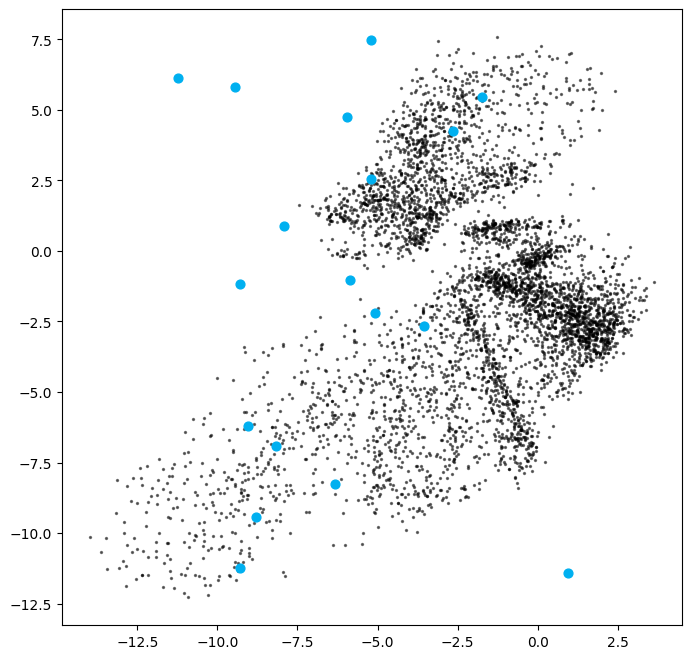

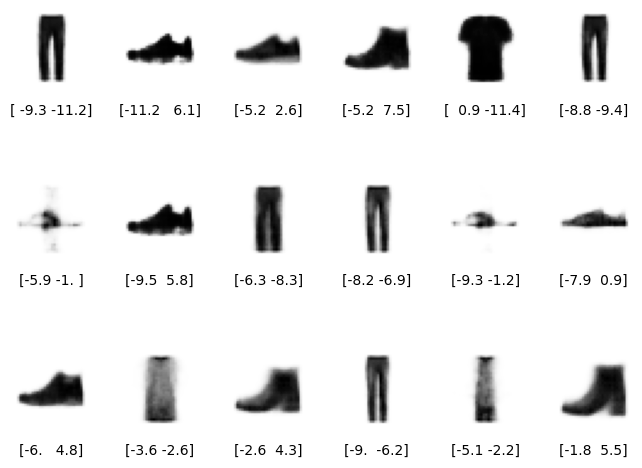

In [70]:
# 그래프로 그립니다.
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에서 새로 생성된 포인트
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드 추가
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")